# Project Overview
--Your goal is to utilize each market index(Dow,  S&P, Nasdaq, Russell) for a 20 year period to  predict the 10-Year Treasury Constant Maturity Rate - Does the market(s) provide any insight or predictive capabilities on the 10 year rate.
 -Test your model on data that the model has not seen. How accurate is your model? 
-Get the appropriate metrics to measure the model accuracy

#### Project approach
- Get 20 years of data from yahoo using the data reader api
- download the 10 year Maturity rate data from https://fred.stlouisfed.org/series/DGS10 from 2000 to current
- clean any missing data from the data set
- check the correlation of the data set
- Use a neural network to see if the Adj Close of the indices can predict the value of the 10 year maturity rate

In [1]:
tickers = ["^GSPC", "^DJI", "^RUT", "^IXIC"]

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import seaborn as sns

/Users/berkatbhatti/opt/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [3]:
index_data = pd.DataFrame()

In [4]:
for t in tickers:
    index_data[t] = web.DataReader(t, data_source="yahoo", start = "2000-01-03", end = "2020-06-11")["Adj Close"]

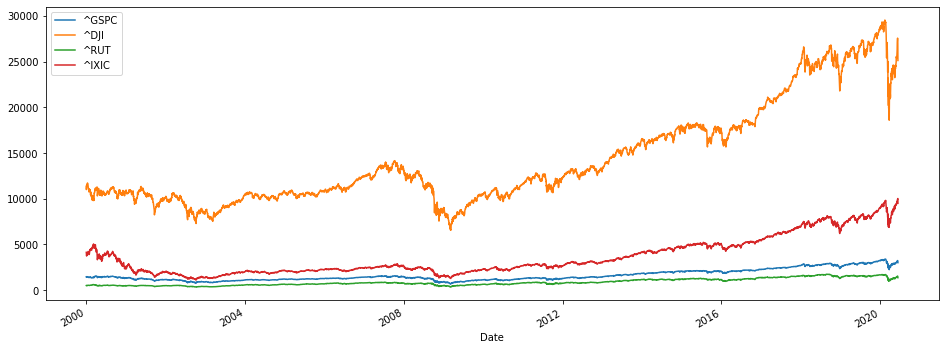

In [5]:
index_data.plot(figsize = (16,6))

### Importing 10 year maturity Data
 - Date will be from 2000-01-03 to 2020-06-11 
 - will check for missing data and replace with appropriate values 

In [6]:
index_data

,^GSPC,^DJI,^RUT,^IXIC
Date,,,,
2000-01-03,1455.219971,11357.509766,496.420013,4131.149902
2000-01-04,1399.420044,10997.929688,478.380005,3901.689941
2000-01-05,1402.109985,11122.650391,478.829987,3877.540039
2000-01-06,1403.449951,11253.259766,475.339996,3727.129883
2000-01-07,1441.469971,11522.559570,488.309998,3882.620117
...,...,...,...,...
2020-06-05,3193.929932,27110.980469,1507.150024,9814.080078
2020-06-08,3232.389893,27572.439453,1536.890015,9924.750000
2020-06-09,3207.179932,27272.300781,1507.050049,9953.750000


In [7]:
data = pd.read_csv("resources/10year_treasury.csv")

In [8]:
data["DATE"] = pd.to_datetime(data["DATE"])

In [9]:
data.set_index('DATE', inplace=True)

In [10]:
data.replace(["."], np.nan, inplace = True)

In [11]:
data["DGS10"] = pd.to_numeric(data["DGS10"])

In [12]:
data

,DGS10
DATE,
2000-01-03,6.58
2000-01-04,6.49
2000-01-05,6.62
2000-01-06,6.57
2000-01-07,6.52
...,...
2020-06-05,0.91
2020-06-08,0.88
2020-06-09,0.84


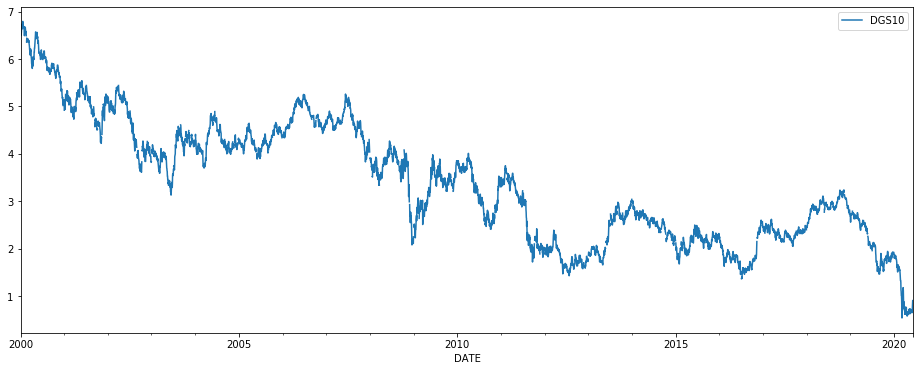

In [13]:
data.plot(figsize = (16,6))

### Concating Data
- Bringing the market data and 10 year maturity together
- We can see that there is a negative correlation betwee nthe markets and the 10 year constant rate

In [14]:
working_data = pd.concat([index_data.dropna(), data], axis=1)

In [15]:
working_data.corr()

,^GSPC,^DJI,^RUT,^IXIC,DGS10
^GSPC,1.000000,0.992037,0.961285,0.985206,-0.556099
^DJI,0.992037,1.000000,0.971825,0.973155,-0.596849
^RUT,0.961285,0.971825,1.000000,0.929849,-0.652752
^IXIC,0.985206,0.973155,0.929849,1.000000,-0.552446
DGS10,-0.556099,-0.596849,-0.652752,-0.552446,1.000000


### Daily Returns
- Volatility of the market and 10 year maturity rate
- The 10 year rate semes to have had volitility between -10 and 10% 
- where as the markets move around 5%+-

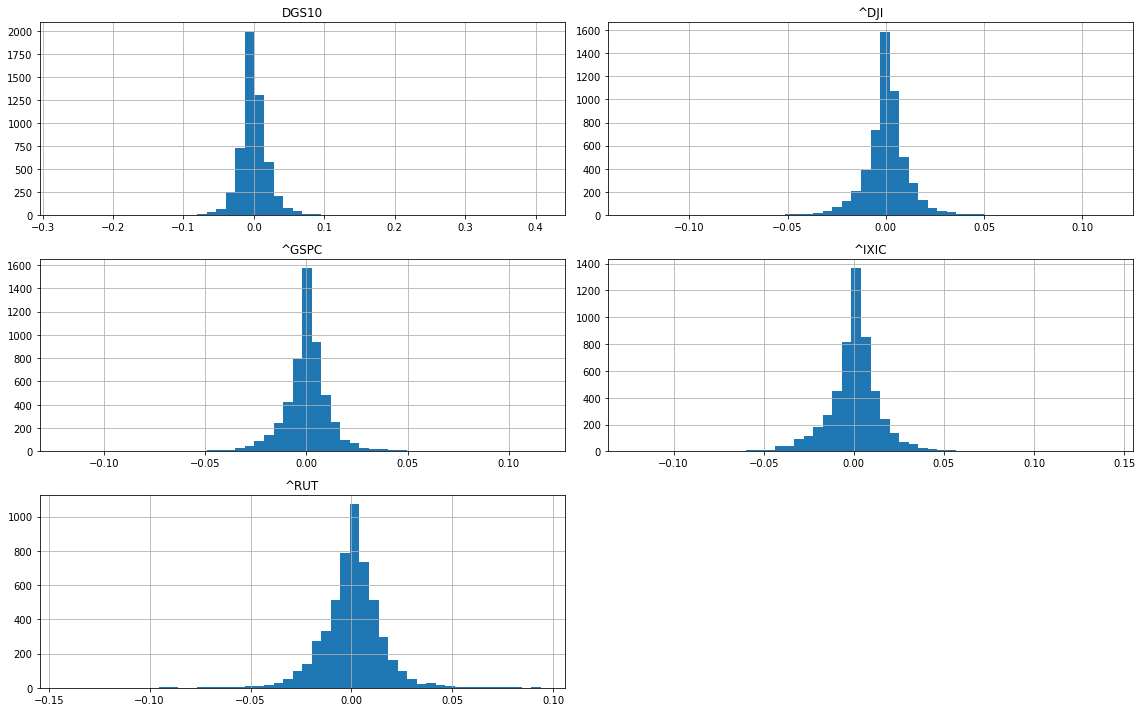

In [16]:
working_data.pct_change().hist(bins = 50, figsize = (16,10))
plt.tight_layout()

### Model Generation 
- Will create a Deep Neural Network that will aim to predict he 10 year maturity rate based on the movement of the markets
- We will need to check for missing data and drop the values for the model
- We can see that there is missing data colored in yellow 

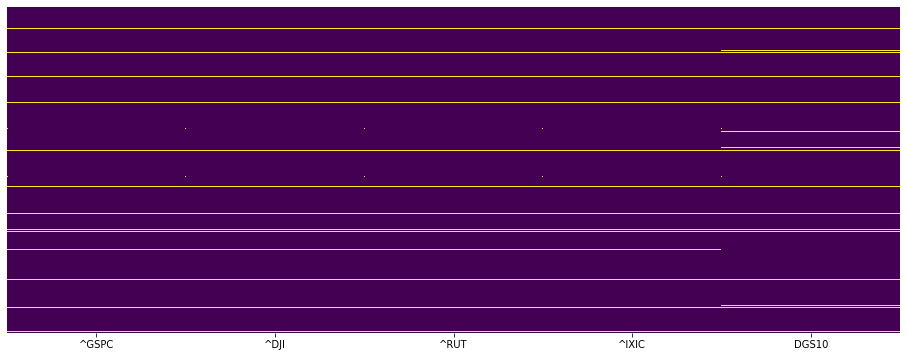

In [17]:
plt.figure(figsize=(16,6))
sns.heatmap(working_data.isnull(), yticklabels=False, cbar=False, cmap="viridis")

In [18]:
working_data.dropna().isnull().sum()

^GSPC    0
^DJI     0
^RUT     0
^IXIC    0
DGS10    0
dtype: int64

In [19]:
X = working_data.dropna().drop("DGS10", axis=1).values
y = working_data.dropna()['DGS10'].values

### Training Testing and Splitting

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

### Scaling
- Training the data for a normal distribution

In [22]:
from sklearn.preprocessing import MinMaxScaler

In [23]:
scalar = MinMaxScaler()

In [24]:
X_train = scalar.fit_transform(X_train)

In [25]:
X_test = scalar.transform(X_test)

In [26]:
X_train.shape

(3574, 4)

In [27]:
X_test.shape

(1532, 4)

## Model Prepration 
- Will use a sequential model 
- Will use a early stopping callback to prevent over fitting

In [28]:
from tensorflow.keras.callbacks import EarlyStopping

In [29]:
stop = EarlyStopping(monitor="val_loss", mode = "min", patience=30)

### Model Creation

In [30]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

## Model Architectire

In [31]:
model = Sequential()
model.add(Dense(units = 30, activation = "relu"))
model.add(Dense(units = 30, activation = "relu"))
model.add(Dense(units = 30, activation = "relu"))
model.add(Dense(units = 20, activation = "relu"))
model.add(Dense(units = 20, activation = "relu"))
model.add(Dense(units = 20, activation = "relu"))
model.add(Dense(units = 10, activation = "relu"))
model.add(Dense(units = 10, activation = "relu"))
model.add(Dense(units = 10, activation = "relu"))
model.add(Dense(units = 1))
model.compile(loss = "mse", optimizer = "adam")

### Fitting model 

In [32]:
model.fit(X_train,y_train, validation_data=(X_test,y_test), epochs=450, callbacks=[stop])

Train on 3574 samples, validate on 1532 samples
Epoch 1/450
3574/3574 [==============================] - 6s 2ms/sample - loss: 10.1491 - val_loss: 3.2213
Epoch 2/450
3574/3574 [==============================] - 1s 287us/sample - loss: 1.4099 - val_loss: 0.8512
Epoch 3/450
3574/3574 [==============================] - 1s 289us/sample - loss: 0.7515 - val_loss: 0.7005
Epoch 4/450
3574/3574 [==============================] - 1s 295us/sample - loss: 0.6070 - val_loss: 0.5299
Epoch 5/450
3574/3574 [==============================] - 1s 302us/sample - loss: 0.4823 - val_loss: 0.4326
Epoch 6/450
3574/3574 [==============================] - 1s 350us/sample - loss: 0.4083 - val_loss: 0.3694
Epoch 7/450
3574/3574 [==============================] - 1s 338us/sample - loss: 0.3678 - val_loss: 0.3278
Epoch 8/450
3574/3574 [==============================] - 1s 280us/sample - loss: 0.3119 - val_loss: 0.2864
Epoch 9/450
3574/3574 [==============================] - 1s 323us/sample - loss: 0.2752 - val_los

3574/3574 [==============================] - 1s 321us/sample - loss: 0.0774 - val_loss: 0.0729
Epoch 77/450
3574/3574 [==============================] - 1s 300us/sample - loss: 0.0816 - val_loss: 0.0708
Epoch 78/450
3574/3574 [==============================] - 1s 292us/sample - loss: 0.0755 - val_loss: 0.0785
Epoch 79/450
3574/3574 [==============================] - 1s 320us/sample - loss: 0.0802 - val_loss: 0.0689
Epoch 80/450
3574/3574 [==============================] - 1s 305us/sample - loss: 0.0769 - val_loss: 0.0706
Epoch 81/450
3574/3574 [==============================] - 1s 295us/sample - loss: 0.0752 - val_loss: 0.0696
Epoch 82/450
3574/3574 [==============================] - 1s 294us/sample - loss: 0.0721 - val_loss: 0.0678
Epoch 83/450
3574/3574 [==============================] - 1s 300us/sample - loss: 0.0766 - val_loss: 0.0675
Epoch 84/450
3574/3574 [==============================] - 1s 312us/sample - loss: 0.0742 - val_loss: 0.0800
Epoch 85/450
3574/3574 [=================

3574/3574 [==============================] - 1s 345us/sample - loss: 0.0613 - val_loss: 0.0611
Epoch 152/450
3574/3574 [==============================] - 1s 307us/sample - loss: 0.0601 - val_loss: 0.0571
Epoch 153/450
3574/3574 [==============================] - 1s 289us/sample - loss: 0.0618 - val_loss: 0.0699
Epoch 154/450
3574/3574 [==============================] - 1s 309us/sample - loss: 0.0612 - val_loss: 0.0811
Epoch 155/450
3574/3574 [==============================] - 1s 287us/sample - loss: 0.0628 - val_loss: 0.0599
Epoch 156/450
3574/3574 [==============================] - 1s 247us/sample - loss: 0.0572 - val_loss: 0.0754
Epoch 157/450
3574/3574 [==============================] - 1s 347us/sample - loss: 0.0597 - val_loss: 0.0588
Epoch 158/450
3574/3574 [==============================] - 1s 294us/sample - loss: 0.0635 - val_loss: 0.0630
Epoch 159/450
3574/3574 [==============================] - 1s 299us/sample - loss: 0.0634 - val_loss: 0.0703
Epoch 160/450
3574/3574 [========

3574/3574 [==============================] - 1s 293us/sample - loss: 0.0514 - val_loss: 0.0557
Epoch 227/450
3574/3574 [==============================] - 1s 319us/sample - loss: 0.0522 - val_loss: 0.0684
Epoch 228/450
3574/3574 [==============================] - 1s 308us/sample - loss: 0.0564 - val_loss: 0.0529
Epoch 229/450
3574/3574 [==============================] - 1s 281us/sample - loss: 0.0534 - val_loss: 0.0650
Epoch 230/450
3574/3574 [==============================] - 1s 305us/sample - loss: 0.0532 - val_loss: 0.0533
Epoch 231/450
3574/3574 [==============================] - 1s 317us/sample - loss: 0.0575 - val_loss: 0.0673
Epoch 232/450
3574/3574 [==============================] - 1s 283us/sample - loss: 0.0548 - val_loss: 0.0852
Epoch 233/450
3574/3574 [==============================] - 1s 285us/sample - loss: 0.0556 - val_loss: 0.0603
Epoch 234/450
3574/3574 [==============================] - 1s 290us/sample - loss: 0.0504 - val_loss: 0.0717
Epoch 235/450
3574/3574 [========

3574/3574 [==============================] - 1s 303us/sample - loss: 0.0446 - val_loss: 0.0433
Epoch 302/450
3574/3574 [==============================] - 1s 277us/sample - loss: 0.0458 - val_loss: 0.0493
Epoch 303/450
3574/3574 [==============================] - 1s 281us/sample - loss: 0.0454 - val_loss: 0.0480
Epoch 304/450
3574/3574 [==============================] - 1s 276us/sample - loss: 0.0471 - val_loss: 0.0466
Epoch 305/450
3574/3574 [==============================] - 1s 316us/sample - loss: 0.0491 - val_loss: 0.0485
Epoch 306/450
3574/3574 [==============================] - 1s 322us/sample - loss: 0.0488 - val_loss: 0.0533
Epoch 307/450
3574/3574 [==============================] - 1s 281us/sample - loss: 0.0467 - val_loss: 0.0431
Epoch 308/450
3574/3574 [==============================] - 1s 292us/sample - loss: 0.0455 - val_loss: 0.0676
Epoch 309/450
3574/3574 [==============================] - 1s 273us/sample - loss: 0.0488 - val_loss: 0.0464
Epoch 310/450
3574/3574 [========

### Model Performnce
- Will take a look at the trainign performance of the model
- Model trained well and did not stop with our early stopping callback. There is still room for training here bur we will see how them model predicts

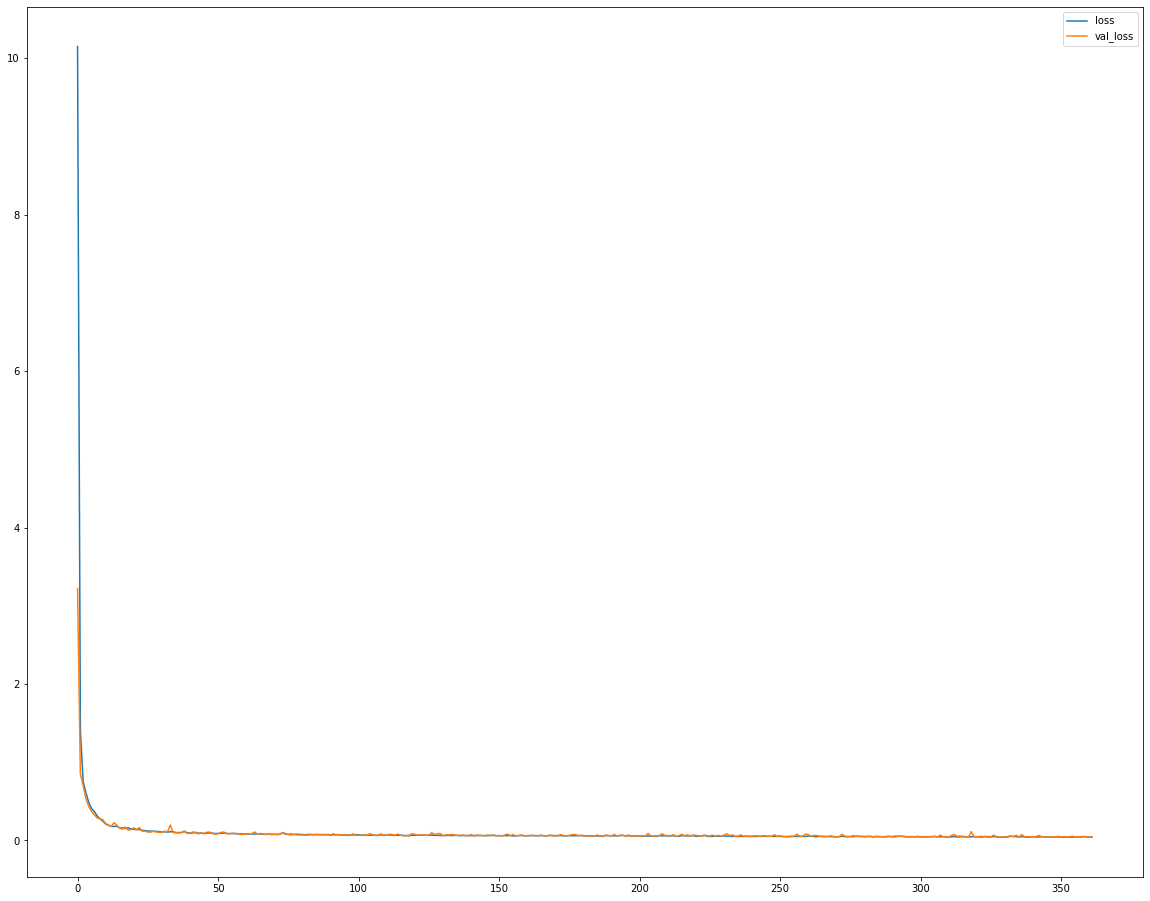

In [33]:
pd.DataFrame(model.history.history).plot(figsize = (20,16))
plt.savefig("resources/model_training_plot.jpg")

In [34]:
#model.save("indexto_10year_yield_Deployed.h5")

In [35]:
#pd.DataFrame(model.history.history).to_csv("resources/model_deployed_history.csv")

### Model Predictions

In [60]:
predictions = model.predict(X_test)

### Will take a look at the metrics 

In [61]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score

In [62]:
mean_absolute_error(y_test, predictions)

0.16210734117902603

In [63]:
mean_squared_error(y_test,predictions)

0.044494963638931365

In [64]:
np.sqrt(mean_squared_error(y_test, predictions))

0.21093829343893764

In [65]:
explained_variance_score(y_test,predictions)

0.9732743961553589

### Predictions on Random Data 

In [66]:
from random import randint
random_index = randint(1, len(working_data.dropna()))
random_day = working_data.dropna().drop(["DGS10"], axis = 1).iloc[random_index]

### Random Data Prepration 
- will need to scale and get the values for the data
- Random day will also need to reshape the new data 

In [67]:
X_train.shape

(3574, 4)

In [68]:
new_day = scalar.transform(random_day.values.reshape(1,4))

In [69]:
new_day

array([[0.60141013, 0.54796147, 0.48457354, 0.65201401]])

## Prediction on Random Data
- The 10 year rate is predicted below 

In [73]:
model.predict(new_day)

array([[0.84757084]], dtype=float32)

### Actual Value

In [74]:
working_data.iloc[random_index]

^GSPC     2870.719971
^DJI     25828.359375
^RUT      1570.060059
^IXIC     7910.589844
DGS10        2.450000
Name: 2019-05-09 00:00:00, dtype: float64

In [75]:
working_data.iloc[random_index]["DGS10"]

2.45

### Lets check todays Prediction got  the 10 year constant Rate
- We will will drop the target which is the 10 Year constant Rate

In [76]:
week_data = pd.DataFrame()

In [77]:
for t in tickers:
    week_data[t] = web.DataReader(t, data_source= "yahoo", start = "2020-6-12")["Adj Close"]

In [78]:
week_data

,^GSPC,^DJI,^RUT,^IXIC
Date,,,,
2020-06-12,3041.310059,25605.539062,1387.680054,9588.809570
2020-06-15,3066.590088,25763.160156,1419.609985,9726.019531
2020-06-16,3124.739990,26289.980469,1452.260010,9895.870117
2020-06-17,3113.489990,26119.609375,1426.530029,9910.530273
2020-06-18,3115.340088,26080.099609,1427.329956,9943.049805
2020-06-19,3097.739990,25871.460938,1418.630005,9946.120117
2020-06-22,3117.860107,26024.960938,1433.530029,10056.480469
2020-06-23,3131.290039,26156.099609,1439.339966,10131.370117
2020-06-24,3050.330078,25445.939453,1389.739990,9909.169922


In [79]:
X_train.shape

(3574, 4)

In [80]:
todays_data = scalar.transform(week_data[-1:].values.reshape(1,4))

In [81]:
model.predict(todays_data)

array([[0.65289325]], dtype=float32)

In [82]:
from tensorflow.keras.models import load_model

In [83]:
deployed_model = load_model("indexto_10year_yield_Deployed.h5")

In [84]:
deployed_model.predict(todays_data)

array([[0.63532346]], dtype=float32)

## june 15th 

In [85]:
june_15th = scalar.transform(week_data.loc["2020-6-17"].values.reshape(1,4))

In [86]:
model.predict(june_15th)

array([[0.65289325]], dtype=float32)